
# MBH Sky Area Compare
Estimate the sky area of a multi-modal MBH posterior using healpix and compare with GWImager estimates


In [1]:
import logging
import matplotlib.pyplot as plt
from lisacattools.catalog import GWCatalogs, GWCatalogType
import healpy as hp
import numpy as np
import ligo.skymap.plot 
import scipy as sp
import pandas as pd
import sys
sys.path.append('../src/')
import constants
import metrics
import sources
import concepts
import subsystems
import background
from lisacattools import OFF # could be CRITICAL, FATAL, ERROR, WARNING, TRACE, INFO, DEBUG, NOTSET
logger = logging.getLogger("lisacattools")
logger.setLevel(OFF) 
#from chainconsumer import ChainConsumer
%matplotlib inline

Load the catalog files



In [2]:
#See: https://github.com/tlittenberg/lisacattools
catPath = "/data/jgbaker/software/lisacattools/tutorial/data/mbh"
catalogs = GWCatalogs.create(GWCatalogType.MBH, catPath, "*.h5")
meta = catalogs.metadata
meta = meta.sort_values(by="observation week")
meta

,author,creation date,observation week,parent,location
MBHcatalog_week001,Neil Cornish,2020-12-17 18:59:07,1.0,None,/data/jgbaker/software/lisacattools/tutorial/d...
MBHcatalog_week003,Neil Cornish,2020-12-17 18:59:07,3.0,MBHcatalog_week001,/data/jgbaker/software/lisacattools/tutorial/d...
MBHcatalog_week004,Neil Cornish,2020-12-17 18:59:07,4.0,MBHcatalog_week003,/data/jgbaker/software/lisacattools/tutorial/d...
MBHcatalog_week005,Neil Cornish,2020-12-17 18:59:08,5.0,MBHcatalog_week004,/data/jgbaker/software/lisacattools/tutorial/d...
MBHcatalog_week006,Neil Cornish,2020-12-17 18:59:08,6.0,MBHcatalog_week005,/data/jgbaker/software/lisacattools/tutorial/d...
MBHcatalog_week007,Neil Cornish,2020-12-17 18:59:09,7.0,MBHcatalog_week006,/data/jgbaker/software/lisacattools/tutorial/d...
MBHcatalog_week008,Neil Cornish,2020-12-17 18:59:09,8.0,MBHcatalog_week007,/data/jgbaker/software/lisacattools/tutorial/d...
MBHcatalog_week009,Neil Cornish,2020-12-17 18:59:10,9.0,MBHcatalog_week008,/data/jgbaker/software/lisacattools/tutorial/d...
MBHcatalog_week010,Neil Cornish,2020-12-17 18:59:11,10.0,MBHcatalog_week009,/data/jgbaker/software/lisacattools/tutorial/d...
MBHcatalog_week011,Neil Cornish,2020-12-17 18:59:12,11.0,MBHcatalog_week010,/data/jgbaker/software/lisacattools/tutorial/d...


load the detections of the most recent catalog



In [3]:
last_cat = catalogs.get_last_catalog()
attr_detections = last_cat.get_attr_detections()
detections = last_cat.get_detections(attr_detections)
detections

,Parent,Log Likelihood,Mass 1,Mass 2,Spin 1,Spin 2,Merger Phase,Barycenter Merge Time,Luminosity Distance,cos ecliptic colatitude,Ecliptic Longitude,Polarization,cos inclination,Detector Merger Time,Ecliptic Latitude,chain file
name,,,,,,,,,,,,,,,,
MBH000373540,,60.282950,11191.400618,1573.347120,0.912502,0.627869,1.555474,3.735402e+05,22.205113,0.288597,2.336538,1.684530,-0.316716,373452.5,0.292761,MBH_wk015C.h5
MBH001865195,MBH001865195,164.506458,24034.822836,8748.509775,0.972429,0.918015,2.297636,1.865195e+06,95.079793,0.195796,3.250084,2.404726,-0.500549,1864860.0,0.197069,MBH_wk015C.h5
MBH002301433,,67.615841,12659.907280,3912.600441,0.961883,0.867574,1.575534,2.301434e+06,34.400859,0.373100,1.242727,1.585468,-0.013747,2301210.0,0.382348,MBH_wk015C.h5
MBH004556400,MBH004556400,243.337498,15868.967713,9036.333963,0.977598,0.962171,1.671275,4.556400e+06,28.921349,0.756914,0.471104,1.576525,-0.410775,4556105.0,0.858578,MBH_wk015C.h5
MBH004650719,MBH004650719,446.562104,22450.923508,8796.170612,0.974075,0.933973,1.493337,4.650720e+06,59.148264,-0.182069,1.626839,1.601119,0.460113,4650671.0,-0.183090,MBH_wk015C.h5
MBH005546845,MBH005546845,652.996924,13238.473697,2707.606755,0.986599,0.903154,1.673776,5.546846e+06,30.323258,0.480294,3.662275,1.810179,-0.800118,5547205.0,0.500989,MBH_wk015C.h5
MBH006058694,MBH006058694,119.338404,10349.085349,3303.282920,0.967010,0.885836,1.614070,6.058695e+06,47.235091,0.333101,1.464468,1.373326,-0.442646,6058450.0,0.339590,MBH_wk015C.h5
MBH006253789,MBH006253789,260.016246,51499.191655,5166.812496,0.990408,0.815457,1.460127,6.253789e+06,24.506354,0.592016,6.084030,1.503608,-0.374348,6253739.0,0.633558,MBH_wk015C.h5
MBH007449510,MBH007449510,72.207804,38276.504295,2615.575967,0.970797,0.368108,1.559661,7.449511e+06,100.930430,-0.682983,0.640946,1.612438,0.667808,7449392.0,-0.751839,MBH_wk015C.h5


### Compute Area using Coherent Diffraction Limit

#### Define Concept (LISA)

In [4]:
model = concepts.LISASciRDv1.copy()
modelName = model.get('label')
model = background.add2model(model)     # add galactic background model

#### Define Sources
Use parameters from catalog

In [5]:
sourceList = list()
det = list(detections.index)
for d in det:
    source = {
            'type' : 'chirp',
            'label': d,
            'm1' : detections.loc[d]['Mass 1'],
            'm2' : detections.loc[d]['Mass 2'],
            'dl' : detections.loc[d]['Luminosity Distance']*1e6
    }
    sourceList.append(source)                  # add the source to list


#### Perform the observations
First compute the SNR

In [6]:
obs = list()
for s in sourceList:
    ob = metrics.getSourceSnr(s,model,-detections.loc[s['label']]['Detector Merger Time'])
    ob = metrics.getResolution(ob)
    #ob = metrics.getSNRandSkyResolution(s,model,Nsamp=100,Tmax=-detections.loc[s['label']]['Detector Merger Time'])

    obs.append(ob)
obs_old =  obs   

In [7]:
obs = list()
for s in sourceList:
    #ob = metrics.getSourceSnr(s,model,-detections.loc[s['label']]['Detector Merger Time'])
    #ob = metrics.getResolution(ob)
    ob = metrics.getSNRandSkyResolution(s,model,Nsamp=100,Tmax=detections.loc[s['label']]['Detector Merger Time']/constants.year)

    obs.append(ob)

rough tstart = -373452.5 0.007517943453283381 < f < 0.8988530865482097
ncut= 33 n= 967
tstart = -373452.5 t[0]= -374220.78266706085 0.008804975313182601 < f < 0.8988530865482097
rough tstart = -1864860.0 0.0018281292400574127 < f < 0.42671881429633557
ncut= 28 n= 972
tstart = -1864860.0 t[0]= -1891694.908729534 0.0021300070765128375 < f < 0.42671881429633557
rough tstart = -2301210.0 0.0026661549751458005 < f < 0.8178848842692886
ncut= 32 n= 968
tstart = -2301210.0 t[0]= -2327521.942954508 0.003202896204324915 < f < 0.8178848842692886
rough tstart = -4556105.0 0.0014578061297023867 < f < 0.6036809220061679
ncut= 27 n= 973
tstart = -4556105.0 t[0]= -4569898.679483623 0.0017156646852735376 < f < 0.6036809220061679
rough tstart = -4650671.0 0.0013198896794378223 < f < 0.45378916818424203
ncut= 30 n= 970
tstart = -4650671.0 t[0]= -4684506.7950035 0.0015729078990480145 < f < 0.45378916818424203
rough tstart = -5547205.0 0.0021518868609759867 < f < 0.7804259472069618
ncut= 38 n= 962
tstart =

In [8]:
obs[1].get('SNR')

13.36810250411969

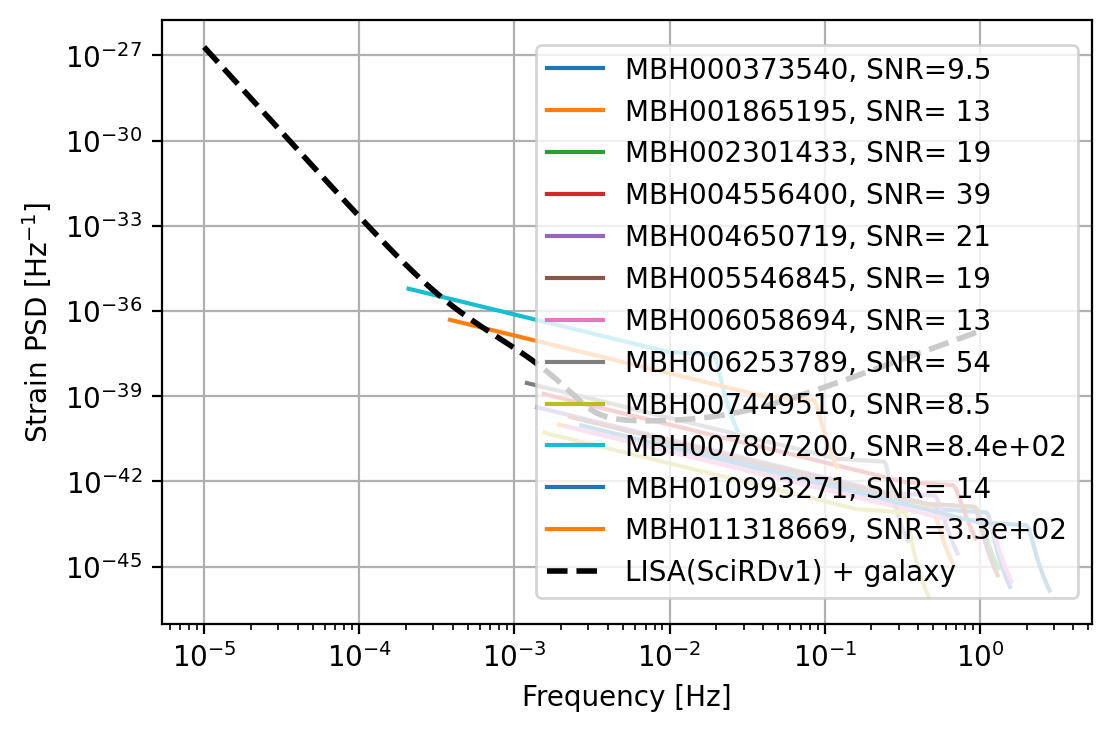

In [9]:
# sensitivity plot
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
f = np.logspace(-5,0,1000)
for ob in obs_old:
    lbl='%s, SNR=%3.2g' % (ob.get('source').get('label'), ob.get('SNR'))
    ax.plot(ob.get('f')[1:],
        np.abs(ob.get('h')[1:]**2)*np.diff(ob.get('f')),
            linestyle='-',label=lbl)
 
ax.plot(f,metrics.makeSensitivity(f,ob.get('model')),color = 'black', linewidth=2.0,linestyle='--',label=ob.get('model').get('label'))


ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain PSD [Hz$^{-1}$]')
plt.legend(loc='right')
ax.grid(True)
#plt.savefig('../plots/%s_source_sensitvities.png' % modelName)

In [10]:
display(obs[0].keys())

dict_keys(['source', 'model', 'f', 'SNR of t', 'Angular Resolution of t', 'Angle Variance (orbit) of t', 'Angle Variance (const) of t', 'Angle Variance (sep) of t', 'Effective omega of t', 'Effective D of t', 't', 'SNR', 'Angular Resolution', 'Angle Variance (orbit)', 'Angle Variance (const)', 'Angle Variance (sep)', 'Effective omega', 'Effective D'])

In [11]:
t_table = 0 # time before merger for generating table
t = obs[0].get('t')
i_table = np.clip(np.argmin(np.abs(t-t_table)),0,np.size(t)-1)
t = obs_old[0].get('t')
i_table_old = np.clip(np.argmin(np.abs(t-t_table)),0,np.size(t)-1)
names = list()
SNRs = list()
res = list()
oldSNRs = list()
oldres = list()
oldobtimes = list()
for iob in range(len(obs)):
    ob=obs[iob]
    oldob=obs_old[iob]
    names.append(ob.get('source').get('label'))
    oldSNRs.append(oldob.get('SNR of t')[i_table_old])
    SNRs.append(ob.get('SNR of t')[i_table])
    res.append(ob.get('Angular Resolution of t')[i_table]/1e-3)
    oldres.append(oldob.get('Angular Resolution of t')[i_table_old]/1e-3)
    oldobtimes.append(-(oldob.get('observation time')-t_table)*365/constants.year)

df = pd.DataFrame(index = names, data = {
    'Old SNR' : oldSNRs,
    'SNR' : SNRs,
    'Old Angular Resolution [mrad]' : oldres,
    'Angular Resolution [mrad]' : res,
    'Old Observation Time [days]' : oldobtimes
})

df['Old Angular Resolution [arcsec]']= df['Old Angular Resolution [mrad]']*1e-3*180/np.pi*3600
df['Angular Resolution [arcsec]']= df['Angular Resolution [mrad]']*1e-3*180/np.pi*3600
df[['Old SNR', 'SNR', 'Old Observation Time [days]', 'Old Angular Resolution [mrad]', 'Angular Resolution [mrad]', 'Old Angular Resolution [arcsec]']]

,Old SNR,SNR,Old Observation Time [days],Old Angular Resolution [mrad],Angular Resolution [mrad],Old Angular Resolution [arcsec]
MBH000373540,9.543958,8.670316,0.001314,415.336123,235.053748,85669.224888
MBH001865195,13.460889,13.368103,1.377102,404.916825,297.404495,83520.090550
MBH002301433,19.261532,18.488775,10.004151,118.556848,184.137119,24454.105204
MBH004556400,38.599587,38.465743,14.334296,96.661334,92.643746,19937.831305
MBH004650719,21.378114,21.316548,5.029675,205.449524,172.923135,42377.006214
MBH005546845,19.395447,18.890323,16.326135,72.376514,98.167655,14928.727653
MBH006058694,12.520999,12.267203,4.279381,111.634177,142.120874,23026.201965
MBH006253789,54.381920,54.256864,17.643539,73.975838,64.832543,15258.611928
MBH007449510,8.507810,8.459068,-0.000000,239.513536,269.914229,49403.213126
MBH007807200,843.552224,821.830288,36.195143,5.224842,7.112466,1077.701050


In [12]:
display(obs)

[{'source': {'type': 'chirp',
   'label': 'MBH000373540',
   'm1': 11191.400617795,
   'm2': 1573.3471201950001,
   'dl': 22205113.285770003},
  'model': {'label': 'LISA(SciRDv1) + galaxy',
   'sqSacc_ASD': [[3e-15, 1.2e-18], [0, -1]],
   'sqSoms_ASD': [[1.5e-11, 6e-17], [0, -2]],
   'Lconst': 2500000000.0,
   'Dsep': 0,
   'Rorbit': 1.0,
   'Torbit': 1.0,
   'Nindep': 2,
   'SciDuration': 4,
   'background': <function background.GBF_model_TN(f, instrParams, nativeParams=None)>},
  'f': array([0.00909505, 0.00935127, 0.00961472, 0.00988559, 0.01016408,
         0.01045043, 0.01074484, 0.01109882, 0.0114115 , 0.01173298,
         0.01206352, 0.01240338, 0.01275281, 0.01311208, 0.01348148,
         0.01392561, 0.01431793, 0.01472129, 0.01513602, 0.01556244,
         0.01600087, 0.016528  , 0.01699363, 0.01747237, 0.01796461,
         0.01847071, 0.01907921, 0.01961671, 0.02016936, 0.02073757,
         0.02132179, 0.02202422, 0.02264469, 0.02328264, 0.02393856,
         0.02472719, 0.0254

### Compare with MCMC results

In [13]:
def areaVres(samples,nside = [32, 64, 128, 256,512,1024],pct=68, singleton_cut=0.10):

    areas = np.zeros_like(nside)
    #singleton_frac = np.zeros_like(nside)
    for idx, ns in enumerate(nside):
        npix = hp.nside2npix(ns)
        pixarea = hp.nside2pixarea(ns,degrees=True)
        hpdata = hp.pixelfunc.ang2pix(ns, 
        np.array(samples['Ecliptic Longitude'])*180/np.pi, 
        np.array(samples['Ecliptic Latitude'])*180/np.pi, 
        nest=False, 
        lonlat=True)
    
        bin_edges = np.arange(-0.5, npix + 0.5, 1.0)
        bin_centers = np.arange(0, npix, 1.0)
        cnt_hp, bins = np.histogram(np.array(hpdata), bin_edges,density=False)
        cnt_sort = np.sort(cnt_hp)[::-1]
        #cnt_hp = cnt_hp / float(samples['Ecliptic Latitude'].count())

        #display(cnt_hp)
        #print(sum(cnt_hp))
        #cnt_sort = np.sort(cnt_hp)[::-1]
        cnt_cum = np.cumsum(cnt_sort)
        #display(cnt_sort)
        ithresh = np.argmin(np.abs(cnt_cum-float(samples['Ecliptic Latitude'].count())*pct/100))
        areas[idx]= bin_centers[ithresh] * pixarea
        singleton_frac = np.sum(cnt_sort[:ithresh+1]<=1)/(ithresh+1)
        if singleton_frac>singleton_cut: areas[idx] = -1
        print(idx,singleton_frac,areas[idx])
        
    return areas

In [14]:
sources = last_cat.get_detections()
nside = np.array([32, 64, 128,256,512,1024])
areas = np.zeros([len(sources),len(nside)])
for idx,source in enumerate(sources):
    samples_attr = last_cat.get_attr_source_samples(sources[idx])
    samples = last_cat.get_source_samples(sources[idx], samples_attr)
    ar = areaVres(samples,nside)
    areas[idx,:]=ar

best_areas=np.array([ar[ar>0][-1] for ar in areas])
df.insert(4,'Angular Resolution MCMC [arcsec]',np.transpose(np.sqrt([best_areas])*3600),True)
df.insert(4,'Angular Resolution estimate ratio',df['Angular Resolution MCMC [arcsec]']/df['Angular Resolution [arcsec]'],True)
df

0 0.0 4441
1 0.0 3551
2 0.0 2542
3 0.0 1542
4 0.3685426036222195 -1
5 0.6094532223009109 -1
0 0.0 3330
1 0.0 2690
2 0.0 1993
3 0.0 1277
4 0.1094241496455983 -1
5 0.4706143761804244 -1
0 0.0 7556
1 0.0 6356
2 0.0 4387
3 0.35322059243946957 -1
4 0.659210905251032 -1
5 0.7478566438747645 -1
0 0.0 67
1 0.0 63
2 0.0 62
3 0.0 61
4 0.0 58
5 0.0 50
0 0.0 3360
1 0.0 2853
2 0.0 2190
3 0.0 1395
4 0.24868762618978946 -1
5 0.5628542251723258 -1
0 0.0 715
1 0.0 698
2 0.0 662
3 0.0 570
4 0.0 398
5 0.308326678542908 -1
0 0.0 2386
1 0.0 2109
2 0.0 1702
3 0.0 1146
4 0.15997241854852612 -1
5 0.5280199579831932 -1
0 0.0 40
1 0.0 39
2 0.0 39
3 0.0 39
4 0.0 38
5 0.0 35
0 0.0 2272
1 0.0 2059
2 0.0 1730
3 0.0 1234
4 0.28236721386056035 -1
5 0.6227004552634025 -1
0 0.0 3
1 0.0 5
2 0.0 6
3 0.0 6
4 0.0 5
5 0.0 5
0 0.0 268
1 0.0 267
2 0.0 264
3 0.0 255
4 0.0 223
5 0.008471121177802944 144
0 0.0 590
1 0.0 575
2 0.0 551
3 0.0 488
4 0.0 352
5 0.2363356836134231 -1


,Old SNR,SNR,Old Angular Resolution [mrad],Angular Resolution [mrad],Angular Resolution estimate ratio,Angular Resolution MCMC [arcsec],Old Observation Time [days],Old Angular Resolution [arcsec],Angular Resolution [arcsec]
MBH000373540,9.543958,8.670316,415.336123,235.053748,2.915764,141365.908196,0.001314,85669.224888,48483.315759
MBH001865195,13.460889,13.368103,404.916825,297.404495,2.097130,128646.492373,1.377102,83520.090550,61344.080553
MBH002301433,19.261532,18.488775,118.556848,184.137119,6.277979,238443.955679,10.004151,24454.105204,37981.007156
MBH004556400,38.599587,38.465743,96.661334,92.643746,1.332129,25455.844123,14.334296,19937.831305,19109.144280
MBH004650719,21.378114,21.316548,205.449524,172.923135,3.769740,134458.915658,5.029675,42377.006214,35667.956980
MBH005546845,19.395447,18.890323,72.376514,98.167655,3.546913,71819.774436,16.326135,14928.727653,20248.532357
MBH006058694,12.520999,12.267203,111.634177,142.120874,4.157304,121869.438335,4.279381,23026.201965,29314.534558
MBH006253789,54.381920,54.256864,73.975838,64.832543,1.592643,21297.887219,17.643539,15258.611928,13372.671846
MBH007449510,8.507810,8.459068,239.513536,269.914229,2.271481,126462.010106,-0.000000,49403.213126,55673.806244
MBH007807200,843.552224,821.830288,5.224842,7.112466,5.487091,8049.844719,36.195143,1077.701050,1467.051341


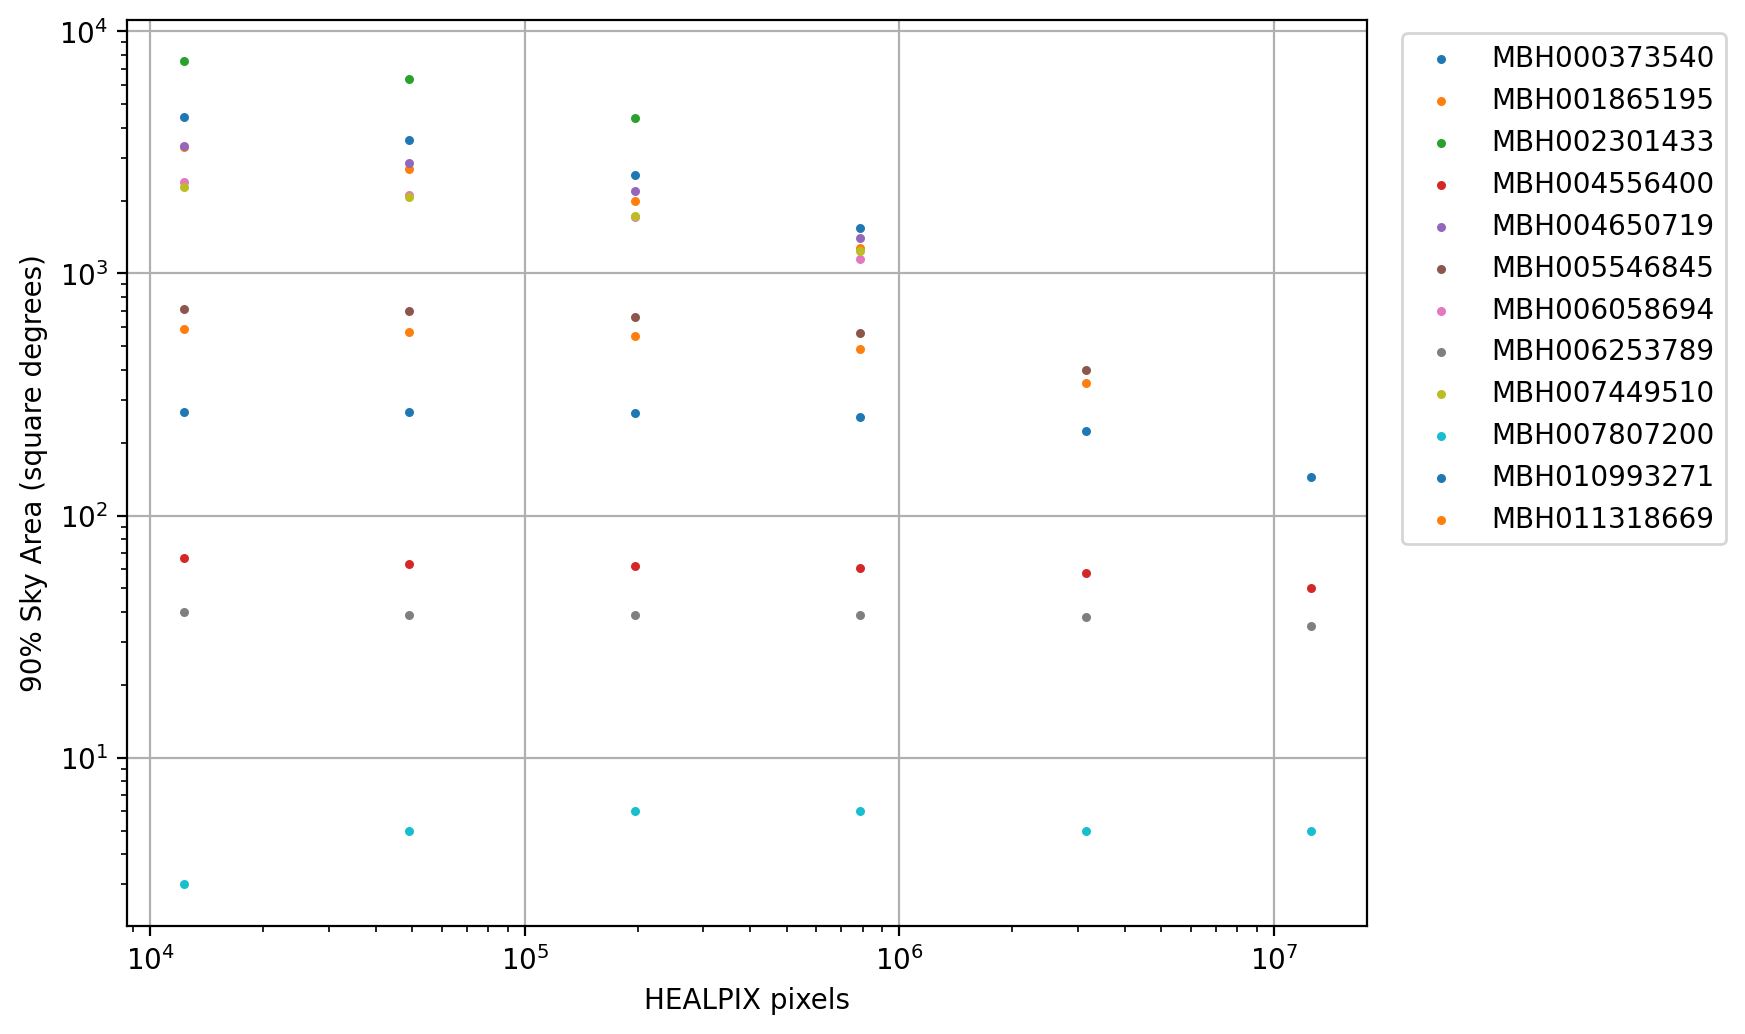

In [15]:
fig,ax = plt.subplots(figsize=(8, 6), dpi=200)
for idx,source in enumerate(sources):
    ax.scatter(hp.nside2npix(np.array(nside)),areas[idx,:],s=5,label=sources[idx])
#for idx,source in enumerate(sources):
#    ax.scatter(hp.nside2npix(np.array(nside)),areas50[idx,:],s=2,label=sources[idx])
plt.grid()
plt.xlabel('HEALPIX pixels')
plt.ylabel('90% Sky Area (square degrees)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.yscale('log')
plt.xscale('log')
#fig.savefig('MBH_HP_areas.png')

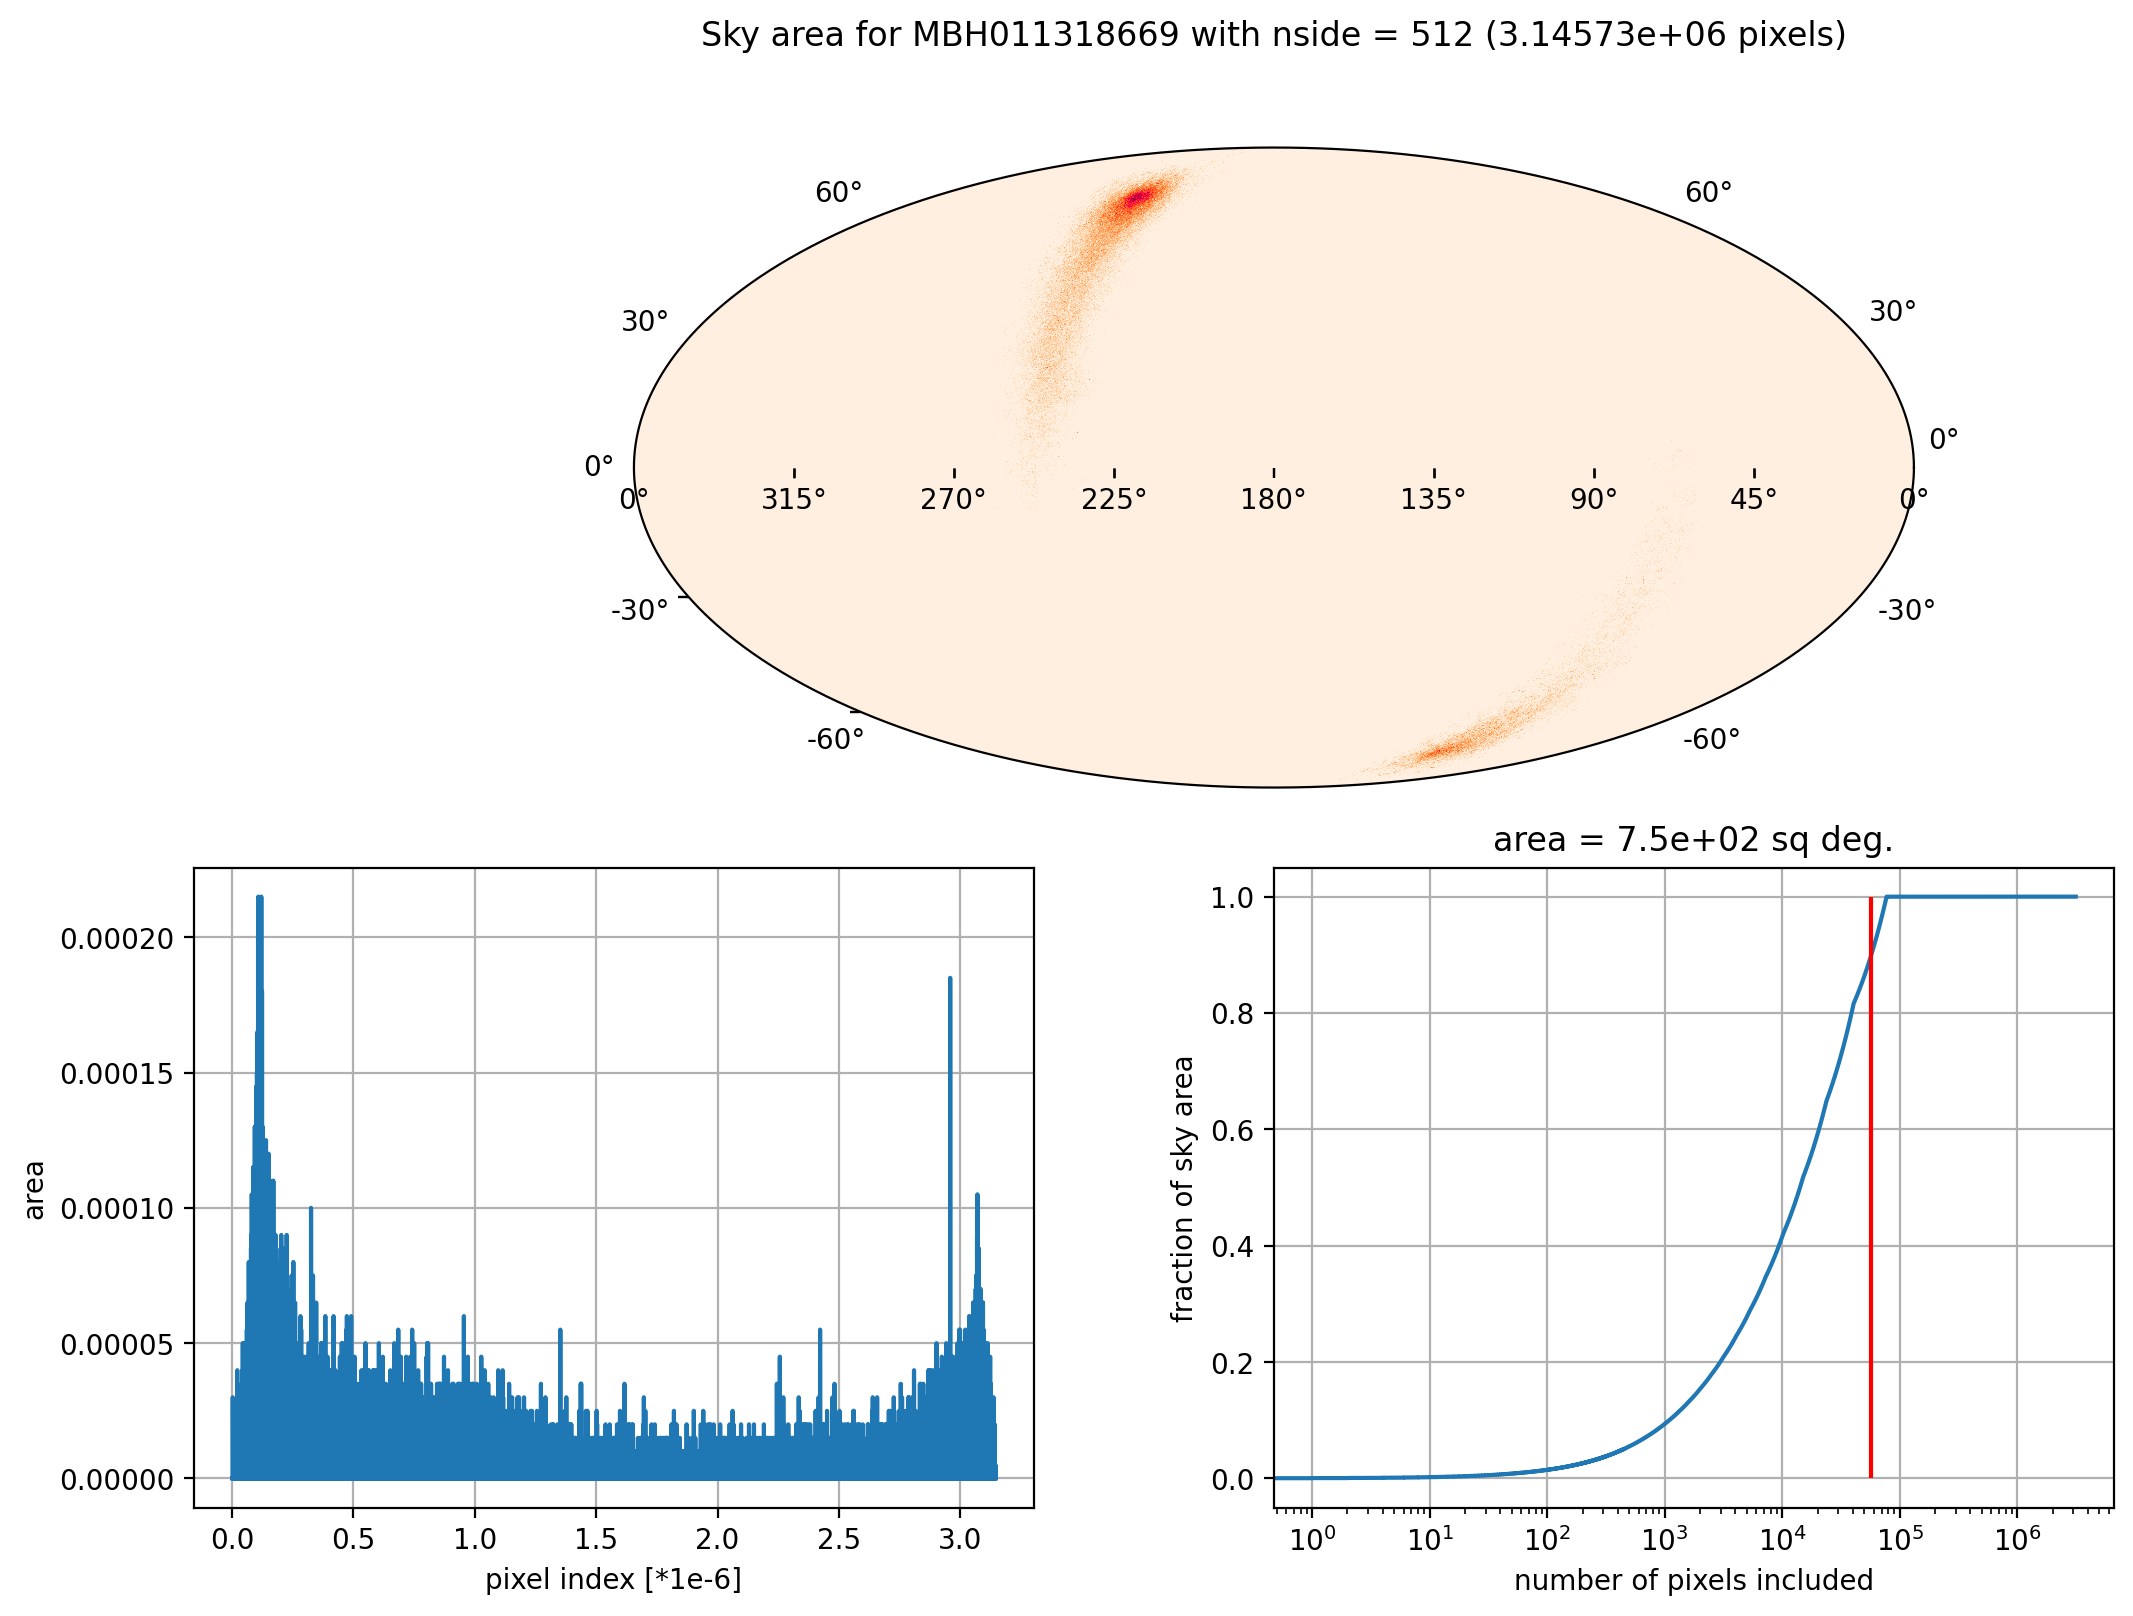

In [20]:
src = 'MBH002301433'
src = 'MBH011318669'
ns = 512

samples_attr = last_cat.get_attr_source_samples(src)
samples = last_cat.get_source_samples(src, samples_attr)


npix = hp.nside2npix(ns)
hpdata = hp.pixelfunc.ang2pix(
    ns, 
    np.array(samples['Ecliptic Longitude'])*180/np.pi, 
    np.array(samples['Ecliptic Latitude'])*180/np.pi, 
    nest=False, 
    lonlat=True)

# Then we bin the healpix
bin_edges = np.arange(-0.5, npix + 0.5, 1.0)
bin_centers = np.arange(0, npix, 1.0)
cnt_hp, bins = np.histogram(np.array(hpdata), bin_edges,density=False)
cnt_hp = cnt_hp / float(samples['Ecliptic Latitude'].count())

cnt_cum = np.cumsum(np.sort(cnt_hp)[::-1])
ithresh = np.argmin(np.abs(cnt_cum-0.90))
pix_thresh = bin_centers[ithresh]
ar = pix_thresh * hp.nside2pixarea(ns,degrees=True)


fig = plt.figure(figsize=(12, 8), dpi=200)

ax = plt.axes(
    [0.1, 0.5, 0.8, 0.4],
    projection ='astro degrees mollweide')
ax.imshow_hpx(cnt_hp, cmap='cylon')

ax1 = plt.axes([0.05,0.05,0.35,0.4])
ax1.step(bin_centers/1e6,cnt_hp)
#ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.grid()
ax1.set_xlabel('pixel index [*1e-6]')
ax1.set_ylabel('area')

ax2 = plt.axes([0.5,0.05,0.35,0.4])
ax2.step(bin_centers,cnt_cum)
ax2.vlines(pix_thresh,0,1,color='red')
ax2.set_xscale('log')
ax2.grid()
ax2.set_xlabel('number of pixels included')
ax2.set_ylabel('fraction of sky area')
ax2.set_title('area = %3.2g sq deg.' % (ar))

fig.suptitle('Sky area for %s with nside = %i (%g pixels)' % (src,ns,npix))
fig.savefig('%s_HP_area_%i.png' % (src,ns))

### Compare

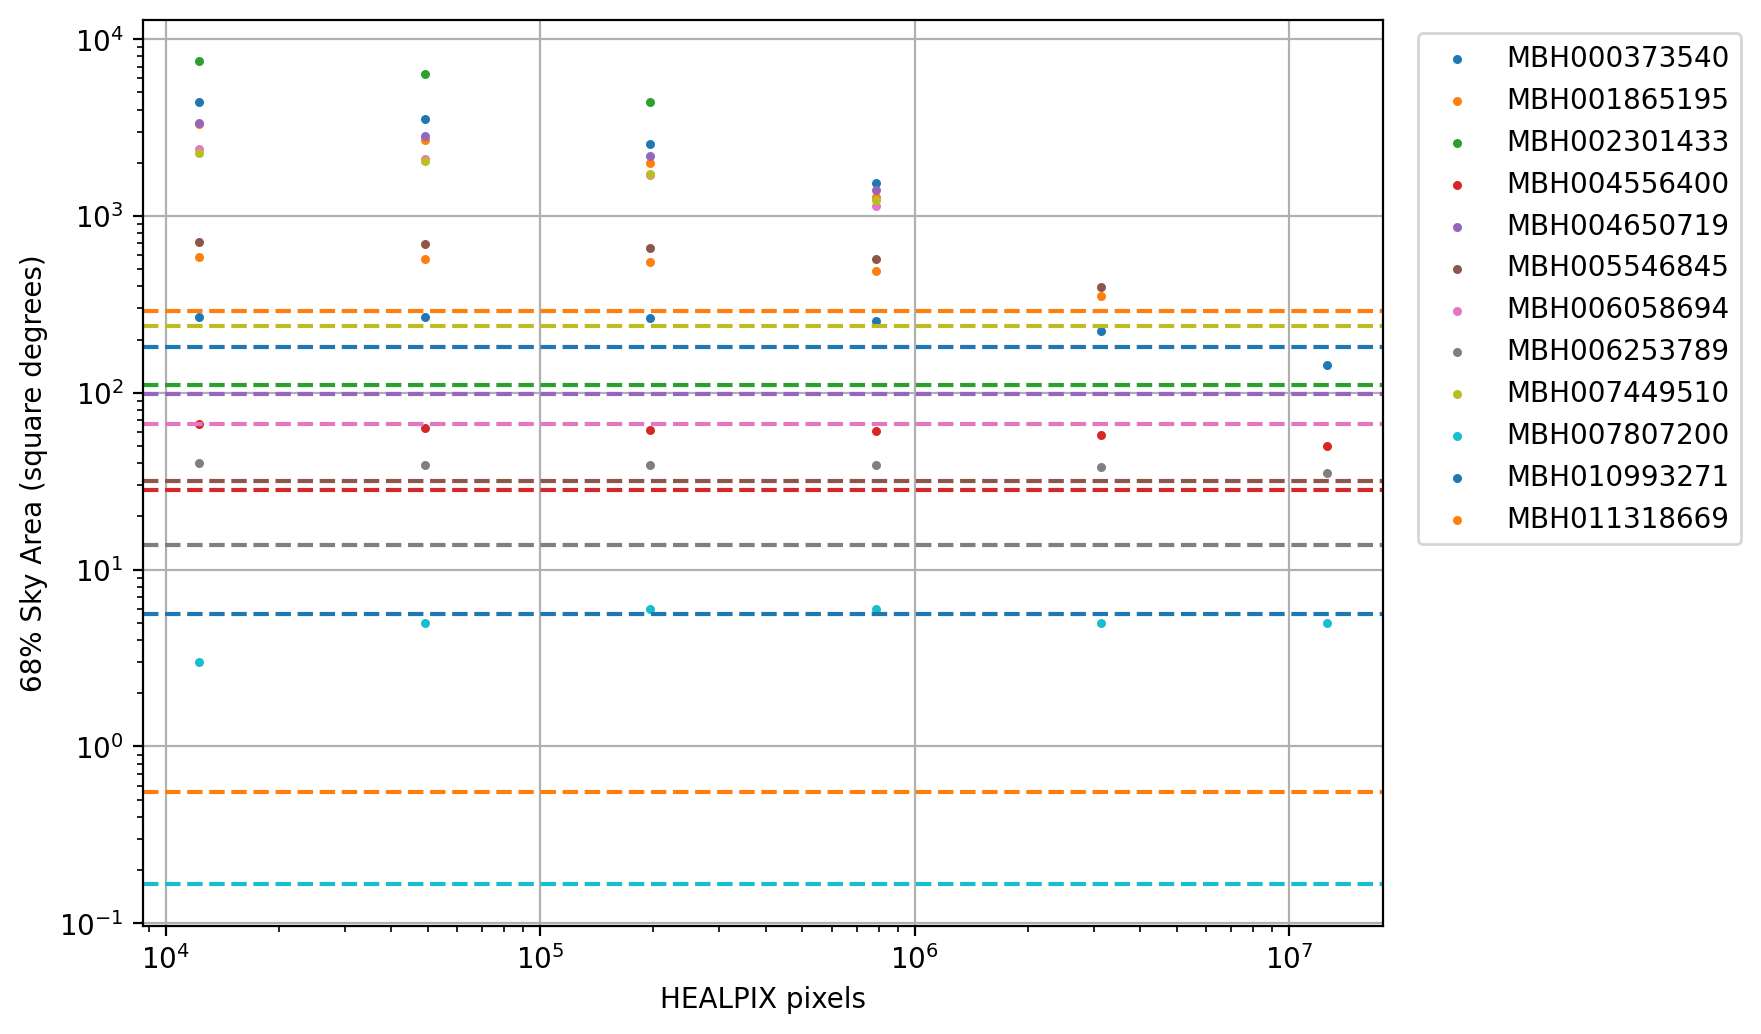

In [17]:
fig,ax = plt.subplots(figsize=(8, 6), dpi=200)
for idx,source in enumerate(sources):
    sc = ax.scatter(hp.nside2npix(np.array(nside)),areas[idx,:],s=5,label=sources[idx])
    col = sc.get_facecolors()[0].tolist()
    CDLA = (df.loc[source]['Angular Resolution [mrad]']*1e-3*180/np.pi)**2
    ax.axhline(CDLA,color=col, linestyle='--')
plt.grid()
plt.xlabel('HEALPIX pixels')
plt.ylabel('68% Sky Area (square degrees)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.yscale('log')
plt.xscale('log')
#fig.savefig('MBH_HP_areas.png')

In [18]:



df[['Old Observation Time [days]','SNR','Angular Resolution [arcsec]','Angular Resolution MCMC [arcsec]','Angular Resolution estimate ratio']]
#df

,Old Observation Time [days],SNR,Angular Resolution [arcsec],Angular Resolution MCMC [arcsec],Angular Resolution estimate ratio
MBH000373540,0.001314,8.670316,48483.315759,141365.908196,2.915764
MBH001865195,1.377102,13.368103,61344.080553,128646.492373,2.097130
MBH002301433,10.004151,18.488775,37981.007156,238443.955679,6.277979
MBH004556400,14.334296,38.465743,19109.144280,25455.844123,1.332129
MBH004650719,5.029675,21.316548,35667.956980,134458.915658,3.769740
MBH005546845,16.326135,18.890323,20248.532357,71819.774436,3.546913
MBH006058694,4.279381,12.267203,29314.534558,121869.438335,4.157304
MBH006253789,17.643539,54.256864,13372.671846,21297.887219,1.592643
MBH007449510,-0.000000,8.459068,55673.806244,126462.010106,2.271481
MBH007807200,36.195143,821.830288,1467.051341,8049.844719,5.487091


In [19]:
best_areas

array([1542., 1277., 4387.,   50., 1395.,  398., 1146.,   35., 1234.,
          5.,  144.,  352.])